# FlowSim vs NS3: Per-Flow FCT Prediction Analysis (CORRECTED)

This notebook compares per-flow Flow Completion Time (FCT) predictions between FlowSim and NS3 using **start_time + FCT sorting** for proper flow matching.

**Key Insight**: Match flows by sorting both datasets by start_time first, then by FCT within each start_time group. This aligns flows that represent the same logical communication patterns.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12

## Load and Match FCT Data by Start Time + FCT Sorting

In [14]:
def load_fct_data(filepath):
    """
    Load FCT data for sorting-based matching.
    Format: src_node dst_node src_port dst_port msg_size start_time fct_ns standalone_fct flow_id
    """
    data = []
    with open(filepath, 'r') as f:
        for index, line in enumerate(f):
            if line.strip():
                parts = line.strip().split()
                if len(parts) >= 9:
                    # Convert hex src/dst to int, extract key info
                    src = int(parts[0], 16)
                    dst = int(parts[1], 16) 
                    msg_size = int(parts[4])      # Column 5: message size
                    start_time = int(parts[5])    # Column 6: start time
                    fct_ns = int(parts[6])        # Column 7: actual FCT
                    i_fct_ns = int(parts[7])        # Column 8: actual FCT
                    flow_id = int(parts[8])       # Column 9: flow_id (for reference only)
                    start_time_fct = start_time + fct_ns
                    data.append([index, fct_ns, src, dst, msg_size, start_time, flow_id, start_time_fct, i_fct_ns])
    
    return pd.DataFrame(data, columns=['original_index', 'fct_ns', 'src_node', 'dst_node', 'msg_size', 'start_time', 'flow_id', 'start_time_fct', 'i_fct_ns'])

# Load data and sort by start_time + FCT for proper matching
print("Loading FCT data...")
suffix = "_8_8"
ns3_data = load_fct_data(f'results/ns3{suffix}/ns3_fct.txt')
flowsim_data = load_fct_data(f'results/flowsim{suffix}/flowsim_fct.txt')
m4_data = load_fct_data(f'results/m4{suffix}/m4_fct.txt')

print(f"NS3 flows: {len(ns3_data)}")
print(f"FlowSim flows: {len(flowsim_data)}")
print(f"M4 flows: {len(m4_data)}")

# Sort datasets by flow_id to align identical flows across simulators
print(f"\nSorting flows by flow_id for proper matching...")
ns3_sorted = ns3_data.sort_values(['flow_id']).reset_index(drop=True)
flowsim_sorted = flowsim_data.sort_values(['flow_id']).reset_index(drop=True)
m4_sorted = m4_data.sort_values(['flow_id']).reset_index(drop=True)

# print(f"\nSorting flows by msg_size and the sum of start_time and fct_ns for proper matching...")
# ns3_sorted = ns3_data.sort_values(['msg_size', 'start_time']).reset_index(drop=True)
# flowsim_sorted = flowsim_data.sort_values(['msg_size', 'start_time']).reset_index(drop=True)
# m4_sorted = m4_data.sort_values(['msg_size', 'start_time']).reset_index(drop=True)

print(f"NS3 start_time range: {ns3_sorted['start_time'].min()} - {ns3_sorted['start_time'].max()}")
print(f"FlowSim start_time range: {flowsim_sorted['start_time'].min()} - {flowsim_sorted['start_time'].max()}")
print(f"M4 start_time range: {m4_sorted['start_time'].min()} - {m4_sorted['start_time'].max()}")

# Check message size distribution
ns3_msg_sizes = ns3_sorted['msg_size'].unique()
flowsim_msg_sizes = flowsim_sorted['msg_size'].unique()
m4_msg_sizes = m4_sorted['msg_size'].unique()
print(f"\nMessage size distribution:")
print(f"NS3 message sizes: {sorted(ns3_msg_sizes)} ({len(ns3_msg_sizes)} unique)")
print(f"FlowSim message sizes: {sorted(flowsim_msg_sizes)} ({len(flowsim_msg_sizes)} unique)")
print(f"M4 message sizes: {sorted(m4_msg_sizes)} ({len(m4_msg_sizes)} unique)")
print(f"Message sizes all match: {set(ns3_msg_sizes) == set(flowsim_msg_sizes) == set(m4_msg_sizes)}")

# Match flows by sorted order
min_flows_fs = min(len(ns3_sorted), len(flowsim_sorted))
min_flows_m4 = min(len(ns3_sorted), len(m4_sorted))
print(f"Can match {min_flows_fs} flows for FlowSim vs NS3")
print(f"Can match {min_flows_m4} flows for M4 vs NS3")

# Create matched dataframes: FlowSim vs NS3
matched_fs = []
for i in range(min_flows_fs):
    ns3_flow = ns3_sorted.iloc[i]
    flowsim_flow = flowsim_sorted.iloc[i]
    matched_fs.append({
        'index': i,
        'ns3_fct': ns3_flow['fct_ns'],
        'flowsim_fct': flowsim_flow['fct_ns'],
        'ns3_src': ns3_flow['src_node'],
        'ns3_dst': ns3_flow['dst_node'],
        'flowsim_src': flowsim_flow['src_node'],
        'flowsim_dst': flowsim_flow['dst_node'],
        'ns3_start': ns3_flow['start_time'],
        'flowsim_start': flowsim_flow['start_time'],
        'msg_size': ns3_flow['msg_size'],
        'ns3_slowdown': ns3_flow['fct_ns']/ns3_flow['i_fct_ns'],
        'flowsim_slowdown': flowsim_flow['fct_ns']/ns3_flow['i_fct_ns'],
    })
merged_fs = pd.DataFrame(matched_fs)
merged_fs['relative_error'] = abs(merged_fs['flowsim_slowdown'] - merged_fs['ns3_slowdown']) / merged_fs['ns3_slowdown'] * 100
# merged_fs['relative_error'] = merged_fs['ns3_slowdown']

# Create matched dataframes: M4 vs NS3
matched_m4 = []
for i in range(min_flows_m4):
    ns3_flow = ns3_sorted.iloc[i]
    m4_flow = m4_sorted.iloc[i]
    matched_m4.append({
        'index': i,
        'ns3_fct': ns3_flow['fct_ns'],
        'm4_fct': m4_flow['fct_ns'],
        'ns3_src': ns3_flow['src_node'],
        'ns3_dst': ns3_flow['dst_node'],
        'm4_src': m4_flow['src_node'],
        'm4_dst': m4_flow['dst_node'],
        'ns3_start': ns3_flow['start_time'],
        'm4_start': m4_flow['start_time'],
        'msg_size': ns3_flow['msg_size'],
        'ns3_slowdown': ns3_flow['fct_ns']/ns3_flow['i_fct_ns'],
        'm4_slowdown': m4_flow['fct_ns']/ns3_flow['i_fct_ns'],
    })
merged_m4 = pd.DataFrame(matched_m4)
merged_m4['relative_error'] = abs(merged_m4['m4_slowdown'] - merged_m4['ns3_slowdown']) / merged_m4['ns3_slowdown'] * 100
# merged_m4['relative_error'] = merged_m4['m4_slowdown']

# Summaries
print(f"\nFlowSim vs NS3 — matched: {len(merged_fs)} flows")
print(f"Mean relative error: {merged_fs['relative_error'].mean():.4f}%")
print(f"Median relative error: {merged_fs['relative_error'].median():.4f}%")

print(f"\nM4 vs NS3 — matched: {len(merged_m4)} flows")
print(f"Mean relative error: {merged_m4['relative_error'].mean():.4f}%")
print(f"Median relative error: {merged_m4['relative_error'].median():.4f}%")

# Show sample comparisons (first 10)
print("\n🔍 Sample flow comparisons (FlowSim vs NS3):")
for i in range(min(10, len(merged_fs))):
    row = merged_fs.iloc[i]
    start_diff = abs(row['ns3_start'] - row['flowsim_start'])
    msg_size_kb = int(row['msg_size']) // 1024
    print(f"  Flow {i:3d}: NS3={int(row['ns3_fct']):5d}ns, FlowSim={int(row['flowsim_fct']):5d}ns, error={row['relative_error']:+.4f}, size={msg_size_kb}KB, start_diff={start_diff:.0f}ns")

print("\n🔍 Sample flow comparisons (M4 vs NS3):")
for i in range(min(10, len(merged_m4))):
    row = merged_m4.iloc[i]
    start_diff = abs(row['ns3_start'] - row['m4_start'])
    msg_size_kb = int(row['msg_size']) // 1024
    print(f"  Flow {i:3d}: NS3={int(row['ns3_fct']):5d}ns, M4={int(row['m4_fct']):5d}ns, error={row['relative_error']:+.4f}, size={msg_size_kb}KB, start_diff={start_diff:.0f}ns")

# Prepare errors for plotting
errors_fs = merged_fs['relative_error']
errors_m4 = merged_m4['relative_error']

# Error distribution snapshots
print(f"\n📈 Error distribution (FlowSim vs NS3):")
print(f"   Flows with <10% error: {(abs(errors_fs) < 10).sum():,} ({(abs(errors_fs) < 10).mean()*100:.1f}%)")
print(f"   Flows with <1% error: {(abs(errors_fs) < 1).sum():,} ({(abs(errors_fs) < 1).mean()*100:.1f}%)")

print(f"\n📈 Error distribution (M4 vs NS3):")
print(f"   Flows with <10% error: {(abs(errors_m4) < 10).sum():,} ({(abs(errors_m4) < 10).mean()*100:.1f}%)")
print(f"   Flows with <1% error: {(abs(errors_m4) < 1).sum():,} ({(abs(errors_m4) < 1).mean()*100:.1f}%)")

Loading FCT data...
NS3 flows: 15360
FlowSim flows: 15360
M4 flows: 15360

Sorting flows by flow_id for proper matching...
NS3 start_time range: 559010 - 84639529
FlowSim start_time range: 559010 - 76671280
M4 start_time range: 559010 - 26218467

Message size distribution:
NS3 message sizes: [131072, 2097152] (2 unique)
FlowSim message sizes: [131072, 2097152] (2 unique)
M4 message sizes: [131072, 2097152] (2 unique)
Message sizes all match: True
Can match 15360 flows for FlowSim vs NS3
Can match 15360 flows for M4 vs NS3

FlowSim vs NS3 — matched: 15360 flows
Mean relative error: 22.0754%
Median relative error: 11.3292%

M4 vs NS3 — matched: 15360 flows
Mean relative error: 228.0563%
Median relative error: 66.8707%

🔍 Sample flow comparisons (FlowSim vs NS3):
  Flow   0: NS3=232079ns, FlowSim=204031ns, error=+12.0855, size=128KB, start_diff=0ns
  Flow   1: NS3=238338ns, FlowSim=204031ns, error=+14.3943, size=128KB, start_diff=0ns
  Flow   2: NS3=234311ns, FlowSim=204031ns, error=+12.9

## Compare Slowdown Predictions Directly


Slowdown Statistics:
NS3:     mean=7.13, median=6.53, std=4.96
FlowSim: mean=6.41, median=6.41, std=4.62
M4:      mean=5.41, median=2.75, std=6.07


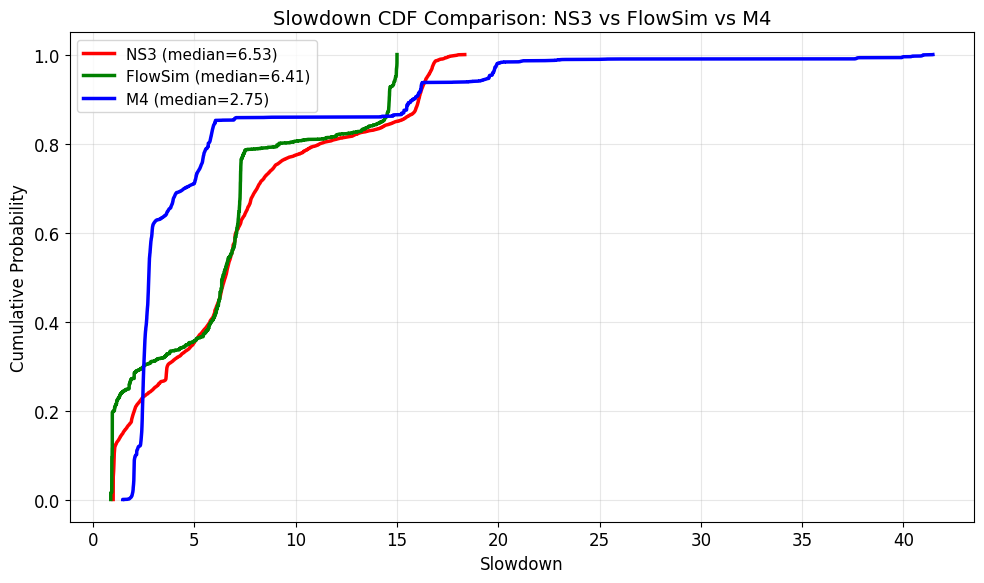

In [15]:
# Extract slowdown values from our matched datasets
ns3_slowdowns = merged_fs['ns3_slowdown'].values
flowsim_slowdowns = merged_fs['flowsim_slowdown'].values  
m4_slowdowns = merged_m4['m4_slowdown'].values

print(f"Slowdown Statistics:")
print(f"NS3:     mean={np.mean(ns3_slowdowns):.2f}, median={np.median(ns3_slowdowns):.2f}, std={np.std(ns3_slowdowns):.2f}")
print(f"FlowSim: mean={np.mean(flowsim_slowdowns):.2f}, median={np.median(flowsim_slowdowns):.2f}, std={np.std(flowsim_slowdowns):.2f}")
print(f"M4:      mean={np.mean(m4_slowdowns):.2f}, median={np.median(m4_slowdowns):.2f}, std={np.std(m4_slowdowns):.2f}")

# CDF comparison of slowdowns
sorted_ns3 = np.sort(ns3_slowdowns)
sorted_fs = np.sort(flowsim_slowdowns)
sorted_m4 = np.sort(m4_slowdowns)

cdf_ns3 = np.arange(1, len(sorted_ns3) + 1) / len(sorted_ns3)
cdf_fs = np.arange(1, len(sorted_fs) + 1) / len(sorted_fs)
cdf_m4 = np.arange(1, len(sorted_m4) + 1) / len(sorted_m4)

plt.figure(figsize=(10, 6))
plt.plot(sorted_ns3, cdf_ns3, linewidth=2.5, color='red', label=f'NS3 (median={np.median(ns3_slowdowns):.2f})')
plt.plot(sorted_fs, cdf_fs, linewidth=2.5, color='green', label=f'FlowSim (median={np.median(flowsim_slowdowns):.2f})')
plt.plot(sorted_m4, cdf_m4, linewidth=2.5, color='blue', label=f'M4 (median={np.median(m4_slowdowns):.2f})')

plt.xlabel('Slowdown', fontsize=12)
plt.ylabel('Cumulative Probability', fontsize=12)
plt.title('Slowdown CDF Comparison: NS3 vs FlowSim vs M4', fontsize=14)
# plt.xscale('log')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Diagnose M4's Skewness Problem



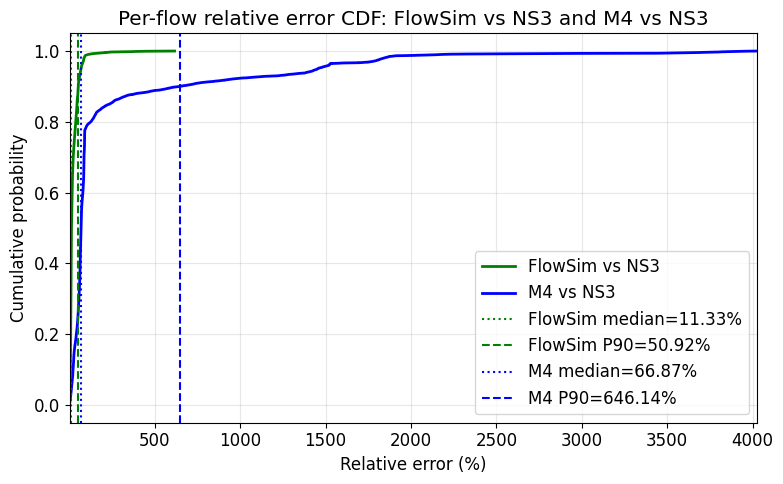

In [16]:
# CDF comparison: FlowSim vs NS3 and M4 vs NS3
# Requires merged_fs and merged_m4 (built above)
errors_fs = merged_fs['relative_error']  # percent
errors_m4 = merged_m4['relative_error']  # percent

sorted_fs = np.sort(errors_fs.values)
sorted_m4 = np.sort(errors_m4.values)

cdf_fs = np.arange(1, len(sorted_fs) + 1) / len(sorted_fs)
cdf_m4 = np.arange(1, len(sorted_m4) + 1) / len(sorted_m4)

plt.figure(figsize=(8, 5))
plt.plot(sorted_fs, cdf_fs, linewidth=2, color='green', label='FlowSim vs NS3')
plt.plot(sorted_m4, cdf_m4, linewidth=2, color='blue', label='M4 vs NS3')

# Markers: median and P90 for both
med_fs = float(np.median(errors_fs))
p90_fs = float(np.percentile(errors_fs, 90))
med_m4 = float(np.median(errors_m4))
p90_m4 = float(np.percentile(errors_m4, 90))
plt.axvline(med_fs, color='green', linestyle=':', linewidth=1.5, label=f'FlowSim median={med_fs:.2f}%')
plt.axvline(p90_fs, color='green', linestyle='--', linewidth=1.5, label=f'FlowSim P90={p90_fs:.2f}%')
plt.axvline(med_m4, color='blue', linestyle=':', linewidth=1.5, label=f'M4 median={med_m4:.2f}%')
plt.axvline(p90_m4, color='blue', linestyle='--', linewidth=1.5, label=f'M4 P90={p90_m4:.2f}%')

plt.xlabel('Relative error (%)')
plt.ylabel('Cumulative probability')
plt.title('Per-flow relative error CDF: FlowSim vs NS3 and M4 vs NS3')
plt.grid(True, alpha=0.3)
plt.legend()
# plt.xscale('log')
# Focus x-range to 1st–99th percentiles across both
x_all = np.concatenate([errors_fs.values, errors_m4.values])
x1 = float(np.percentile(x_all, 1))
x99 = float(np.percentile(x_all, 100))
plt.xlim(x1, x99)
plt.tight_layout()
plt.show()
